# Importing needed modules

In [1]:
import os
import requests
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from transformers import Owlv2Processor, Owlv2ForObjectDetection
from PIL import Image

/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function to visualize the final result of the model

In [8]:
def plot_results(results, texts, image):
    """
    Plots the results of object detection on an image.
    
    Args:
        results (list): List of dictionaries containing the detected object information.
        texts (list): List of text labels corresponding to the detected objects.
        image (PIL.JpegImagePlugin.JpegImageFile): The input image on which the objects are detected.
    """
    boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]
    text = texts[0]
    colors = np.random.random((len(text),3))
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    # Iteration on every boxes, scores and labels
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.detach().cpu().numpy()]

        # Convertion of the coordinates of the box for Matplotlib (x, y, width, length)
        x, y, xmax, ymax = box
        rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=1, edgecolor=colors[label], facecolor='none')
        
        ax.add_patch(rect)
        plt.text(x, y - 10, f'{text[label]}: {round(score.item(), 2)}', color='white', fontsize=8, backgroundcolor=colors[label])
        
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
   
    plt.axis('off')
    plt.show()


# Loading the two needed models

In [3]:
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").cuda()

# Prediction with the models

tensor([0, 0, 0, 2, 2, 2, 0], device='cuda:0')
Detected businessmen figure with confidence 0.111 at location [2746.96, -1.36, 2900.15, 441.51]
Detected businessmen figure with confidence 0.23 at location [849.56, 165.51, 1374.85, 1075.45]
Detected businessmen figure with confidence 0.217 at location [1586.78, 300.3, 2260.43, 1348.02]
Detected Bus figure with confidence 0.655 at location [1340.96, 431.41, 3667.4, 1173.34]
Detected Bus figure with confidence 0.124 at location [1349.89, 440.61, 3647.06, 1054.13]
Detected Bus figure with confidence 0.123 at location [2243.39, 446.49, 3646.02, 1043.54]
Detected businessmen figure with confidence 0.153 at location [780.04, 113.64, 1452.81, 1416.07]


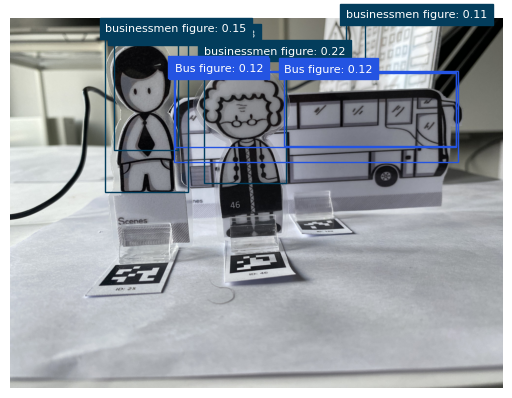

In [9]:
# Initialize processor and model
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# Assuming you have a CUDA device available, move the model to the GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Load the image
path = "/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/data/iLoveIMG IMG 6542.jpg"
image = Image.open(path)

# Example text input
texts = [["businessmen figure", "oldwomen front", "Bus figure"]]

# Generate inputs
inputs = processor(text=texts, images=image, return_tensors="pt")

# Move each tensor in the inputs dictionary to the GPU
inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

# Perform inference 5 times
for _ in range(5):
    # Generate inputs
    inputs = processor(text=texts, images=image, return_tensors="pt")

    # Move each tensor in the inputs dictionary to the GPU
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    


# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
plot_results(results, texts, image)

In [5]:
print(inputs["pixel_values"].shape)

torch.Size([1, 3, 960, 960])


In [6]:
inputs

{'input_ids': tensor([[49406,  8346,  1656,  5274, 49407,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0],
         [49406,  4931,  1507,  2184, 49407,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0],
         [49406,  2840,  5274, 49407,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'),
 'pixel_values': tensor([[[[-0.1274, -0.1048, -0.1028,  ..., -1.7923, -1.7923, -1.7923],
           [-0.1073, -0.1139, -0.1141,  ..., -1.7923, -1.7923, -1.7923],
           [-0.1270, -0.1176, -0.1298,  ..., -1.7923, -1.7923, -1.7923],
           ...,
           [ 0.0690,  0.0690,  0.0690,  ...,  0.0690,  0.0690,  0.0690],
           [ 0.0690,  0.0690,  

# Ploting results

In [6]:
results

[{'scores': tensor([0.1110, 0.2305, 0.2171, 0.6551, 0.1242, 0.1231, 0.1528],
         grad_fn=<IndexBackward0>),
  'labels': tensor([0, 0, 0, 2, 2, 2, 0]),
  'boxes': tensor([[ 2.7470e+03, -1.3645e+00,  2.9002e+03,  4.4151e+02],
          [ 8.4956e+02,  1.6551e+02,  1.3748e+03,  1.0755e+03],
          [ 1.5868e+03,  3.0030e+02,  2.2604e+03,  1.3480e+03],
          [ 1.3410e+03,  4.3141e+02,  3.6674e+03,  1.1733e+03],
          [ 1.3499e+03,  4.4061e+02,  3.6471e+03,  1.0541e+03],
          [ 2.2434e+03,  4.4649e+02,  3.6460e+03,  1.0435e+03],
          [ 7.8004e+02,  1.1364e+02,  1.4528e+03,  1.4161e+03]],
         grad_fn=<IndexBackward0>)}]

Detected businessmen figure with confidence 0.111 at location [2746.96, -1.36, 2900.15, 441.51]
Detected businessmen figure with confidence 0.23 at location [849.56, 165.51, 1374.85, 1075.45]
Detected businessmen figure with confidence 0.217 at location [1586.78, 300.3, 2260.43, 1348.02]
Detected Bus figure with confidence 0.655 at location [1340.96, 431.41, 3667.4, 1173.34]
Detected Bus figure with confidence 0.124 at location [1349.89, 440.61, 3647.06, 1054.13]
Detected Bus figure with confidence 0.123 at location [2243.39, 446.49, 3646.02, 1043.54]
Detected businessmen figure with confidence 0.153 at location [780.04, 113.64, 1452.81, 1416.08]


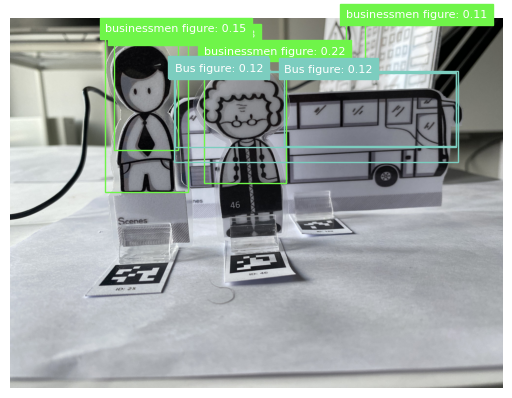

In [19]:
plot_results(results, texts, image)

# Generate dataset

In [33]:
images_directory = "./data/images/"
labels_directory = "./data/labels/"

images_files = os.listdir(images_directory)
labels_files = os.listdir(labels_directory)

dataset = []

for i, image_file in enumerate(images_files):
    image = Image.open(images_directory + image_file)
    label_file = open(labels_directory + image_file.split(".")[0] + ".txt", "r")
    
    label_content = label_file.read().splitlines()[0].split(" ")
    
    label = [float(label)  for label in label_content]
    
    dataset.append({"image_id" : i, "image" : image , "width" : image.width, "height" : image.height, "object" : {"bbox" : [label[1:]], "label" : [int(label[0])], "area" : [0]}})

dataset

[{'image_id': 0,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  'width': 640,
  'height': 480,
  'object': {'bbox': [[0.739063, 0.65625, 0.146875, 0.416667]],
   'label': [0],
   'area': [0]}},
 {'image_id': 1,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  'width': 640,
  'height': 480,
  'object': {'bbox': [[0.476562, 0.588542, 0.18125, 0.422917]],
   'label': [0],
   'area': [0]}},
 {'image_id': 2,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  'width': 640,
  'height': 480,
  'object': {'bbox': [[0.313281, 0.4125, 0.170313, 0.516667]],
   'label': [0],
   'area': [0]}},
 {'image_id': 3,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  'width': 640,
  'height': 480,
  'object': {'bbox': [[0.494531, 0.569792, 0.114063, 0.28125]],
   'label': [0],
   'area': [0]}},
 {'image_id': 4,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  'width

In [1]:
from transformers import Owlv2ImageProcessor, Owlv2ForObjectDetection


/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
processor = Owlv2ImageProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")


In [1]:
import torch

print(torch.cuda.is_available())  # Should print True if CUDA is properly configured
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU

False


/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [4]:
import torch
torch.cuda.empty_cache()


NameError: name 'variables' is not defined

In [6]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |